# ノードのクラス分類（教師あり）

In [151]:
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx

import torch
from torch import nn
from torch.nn import functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx

In [152]:
dataset = KarateClub()

dataset.num_features

34

In [153]:
dataset.num_classes

2

In [154]:
data = dataset[0]

data

Data(edge_index=[2, 156], x=[34, 34], y=[34])

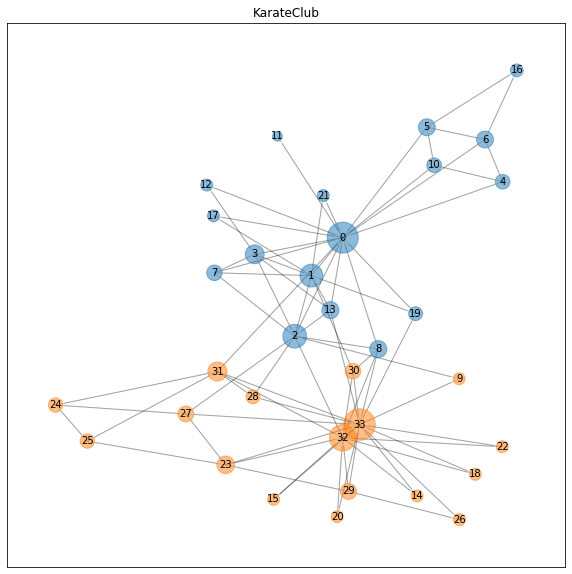

In [155]:
nxg = to_networkx(data)     # networkxのグラフに変換する
pr = nx.pagerank(nxg)       # 可視化のためのページランク計算
pr_max = np.array(list(pr.values())).max()

draw_pos = nx.spring_layout(nxg, seed=0)    # 可視化する際のノード位置

cmap = plt.get_cmap('tab10')
labels = data.y.numpy()
colors = [cmap(l) for l in labels]

plt.figure(figsize=(10, 10))

nx.draw_networkx_nodes(nxg, draw_pos, node_size=[v / pr_max * 1000 for v in pr.values()],
                       node_color=colors, alpha=0.5)
nx.draw_networkx_edges(nxg, draw_pos, arrowstyle='-', alpha=0.2)
nx.draw_networkx_labels(nxg, draw_pos, font_size=10)

plt.title('KarateClub')
plt.show()

In [156]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=16):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim, cached=True)   # Graph Convolution
        self.conv2 = GCNConv(hidden_dim, out_dim, cached=True)

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        return self.conv2(h, edge_index)


In [157]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [158]:
model = Net(dataset.num_features, dataset.num_classes).to(device)

model

Net(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 2)
)

In [159]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# KareteClubはin-memoryなデータセットなので、学習ループの外でデータを読み込める
data = data.to(device)
x, edge_index, y = data.x, data.edge_index, data.y

In [160]:
def accuracy(y_pred, y_true):
    """
    正答率を計算する
    Parameters
    ----------
    y_pred  推論値
    y_true  正解値

    Returns 正答率
    -------

    """
    return (y_pred == y_true).sum().item() / len(y_pred)


In [161]:
acc_list = []
epoch_list = list(range(1, 101))
for epoch in epoch_list:
    # training
    model.train()   # 訓練モード
    optimizer.zero_grad()   # 勾配リセット

    logits = model(x, edge_index)   # 順伝播によるロジット計算
    loss = criterion(logits, y)     # トレーニングデータのみを用いて交差エントロピー
    
    loss.backward()     # 逆伝播
    optimizer.step()

    pred = torch.argmax(logits, dim=1)  # logitのargmaxで推論値を得る
   
    acc = accuracy(pred, y)   # 正答率の計算
    acc_list.append(acc)
    
    print(f'epoch: {epoch}  loss: {loss.item():.6f}  acc.: {acc:.3f}')


epoch: 1  loss: 0.682632  acc.: 0.735
epoch: 2  loss: 0.667512  acc.: 0.882
epoch: 3  loss: 0.653501  acc.: 0.912
epoch: 4  loss: 0.639676  acc.: 0.941
epoch: 5  loss: 0.625323  acc.: 0.971
epoch: 6  loss: 0.610246  acc.: 0.971
epoch: 7  loss: 0.594534  acc.: 0.971
epoch: 8  loss: 0.577512  acc.: 0.971
epoch: 9  loss: 0.559366  acc.: 0.971
epoch: 10  loss: 0.540002  acc.: 0.971
epoch: 11  loss: 0.519646  acc.: 0.971
epoch: 12  loss: 0.498703  acc.: 0.971
epoch: 13  loss: 0.477304  acc.: 0.971
epoch: 14  loss: 0.455041  acc.: 0.971
epoch: 15  loss: 0.432532  acc.: 0.971
epoch: 16  loss: 0.409968  acc.: 0.971
epoch: 17  loss: 0.387438  acc.: 0.971
epoch: 18  loss: 0.365228  acc.: 0.971
epoch: 19  loss: 0.343506  acc.: 0.971
epoch: 20  loss: 0.322442  acc.: 0.971
epoch: 21  loss: 0.302158  acc.: 0.971
epoch: 22  loss: 0.282741  acc.: 0.971
epoch: 23  loss: 0.264224  acc.: 0.971
epoch: 24  loss: 0.246695  acc.: 0.971
epoch: 25  loss: 0.230273  acc.: 0.971
epoch: 26  loss: 0.214930  acc.: 0

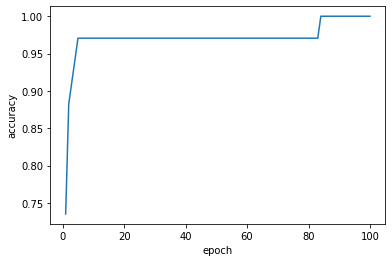

In [164]:
plt.plot(epoch_list, acc_list)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()